# Imports

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('darkgrid')
random_state = 42

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

# Data frame creation

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
data = fetch_ucirepo(id=350) 
  
# convert features and targets to a pandas DataFrame
df = pd.DataFrame(data.data.features, columns=data.data.feature_names)
df['DEFAULT'] = data.data.targets  # Add the target column to the DataFrame

# Rename columns
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
df.rename(columns=lambda x: x.upper(), inplace=True)

# Rename X0-Xn columns to more descriptive names
df.rename(columns={
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_1',
    'X7': 'PAY_2',
    'X8': 'PAY_3',
    'X9': 'PAY_4',
    'X10': 'PAY_5',
    'X11': 'PAY_6',
    'X12': 'BILL_AMT1',
    'X13': 'BILL_AMT2',
    'X14': 'BILL_AMT3',
    'X15': 'BILL_AMT4',
    'X16': 'BILL_AMT5',
    'X17': 'BILL_AMT6',
    'X18': 'PAY_AMT1',
    'X19': 'PAY_AMT2',
    'X20': 'PAY_AMT3',
    'X21': 'PAY_AMT4',
    'X22': 'PAY_AMT5',
    'X23': 'PAY_AMT6',
    'X24': 'DEFAULT'
}, inplace=True)


df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

# Data Cleaning
LIMIT BAL, SEX, and AGE attributes have correct values as defined
but MARRIAGE and EDUCATION both have unexpected categories.
MARRIAGE should range from 1 to 3 (but is 0 to 3) and EDUCATION should range from 1 to 4 (but is 0 to 6)
We should remove these categories so they do not affect the data

In [8]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()
print(f"Dataset size before:\t{df.shape[0]}")

# Remove rows of X3 with value 0, 5, or 6
df = df[~df['EDUCATION'].isin([0, 5, 6])]
df['EDUCATION'].describe()

# Remove rows of X4 with value 0
df = df[~df['MARRIAGE'].isin([0])]
df['MARRIAGE'].describe()

print(f"Dataset size after:\t{df.shape[0]}")

Dataset size before:	30000
Dataset size after:	29601


PAY_1 - PAY_6 should have values of -1, 1, 2, 3, up to 9 but instead have a minimum of -2 and a max of 8, so it looks like the data is one number off so we need to add 1 to each value

In [9]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

# Add 1 to all values in the PAY_X columns
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] += 1
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()



,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,0.985068,0.868687,0.836560,0.781697,0.736022,0.712442
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


Nothing wrong in BILL_AMNT or PAY_AMNT

In [10]:


df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()


df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()




,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000
mean,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374
std,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


# Key Statistics and Data Presentation

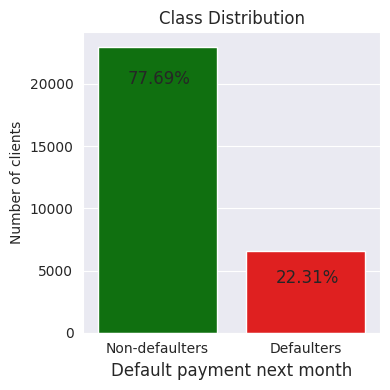

In [11]:

# Only 6605/22996 are defaulters which is the minority and will be less important to the model
df['DEFAULT'].value_counts()

plt.figure(figsize = (4,4))
graph_target = sns.countplot(x="DEFAULT", data=df, palette=['Green','Red'])

# Plot % of each class of the whole
plt.text(-0.2, 20000, f'{df["DEFAULT"].value_counts()[0]/df.shape[0]*100:.2f}%', fontsize=12)
plt.text(0.8, 4000, f'{df["DEFAULT"].value_counts()[1]/df.shape[0]*100:.2f}%', fontsize=12)


plt.title('Class Distribution')
plt.xticks([0,1],['Non-defaulters', 'Defaulters'])
plt.xlabel('Default payment next month', fontsize=12)
plt.ylabel('Number of clients')
plt.tight_layout()
plt.show()

Key stats

In [12]:
numerical_stats = df.describe().T  # Transpose for better readability
numerical_stats['median'] = df.median()  # Add median to the statistics

# Display key statistics
print(numerical_stats[['mean', 'median', 'std']])

                    mean    median            std
LIMIT_BAL  167550.544914  140000.0  129944.020953
SEX             1.603189       2.0       0.489244
EDUCATION       1.815479       2.0       0.710399
MARRIAGE        1.555454       2.0       0.518092
AGE            35.464072      34.0       9.213243
PAY_1           0.985068       1.0       1.124503
PAY_2           0.868687       1.0       1.199642
PAY_3           0.836560       1.0       1.199793
PAY_4           0.781697       1.0       1.172220
PAY_5           0.736022       1.0       1.136217
PAY_6           0.712442       1.0       1.152206
BILL_AMT1   50957.432012   22259.0   73370.242404
BILL_AMT2   48942.189554   21050.0   70923.985151
BILL_AMT3   46803.203270   20035.0   69123.892106
BILL_AMT4   43122.554204   19005.0   64196.383913
BILL_AMT5   40235.545184   18091.0   60699.344884
BILL_AMT6   38858.449816   17118.0   59519.893043
PAY_AMT1     5649.560319    2100.0   16568.264941
PAY_AMT2     5894.788386    2007.0   23089.193621


### Analysis of Key Statistics

#### 1. **Credit Limit (`LIMIT_BAL`)**
   - **Mean**: 167,550.54  
   - **Median**: 140,000.0  
   - **Std**: 129,944.02  
   - **Description**: Represents the total credit limit (in NT dollars), including individual and family credit.  
   - **Analysis**:  
     - The mean is higher than the median, indicating a right-skewed distribution (a few customers have very high credit limits).  
     - The high standard deviation suggests significant variability in credit limits among customers.  

#### 2. **Demographics**
   - **Gender (`SEX`)**:
     - **Mean**: 1.60 (closer to 2, which represents females).  
     - **Median**: 2.0  
     - **Std**: 0.49  
     - **Description**: Gender of the customer (1 = male, 2 = female).  
     - **Analysis**: The dataset has a slightly higher proportion of females than males.  

   - **Education (`EDUCATION`)**:
     - **Mean**: 1.82  
     - **Median**: 2.0  
     - **Std**: 0.71  
     - **Description**: Education level of the customer (1 = graduate school, 2 = university, 3 = high school, 4 = others).  
     - **Analysis**: Most customers have university-level education (coded as 2).  

   - **Marital Status (`MARRIAGE`)**:
     - **Mean**: 1.56  
     - **Median**: 2.0  
     - **Std**: 0.52  
     - **Description**: Marital status of the customer (1 = married, 2 = single, 3 = others).  
     - **Analysis**: Most customers are single (coded as 2), with some variability.  

   - **Age (`AGE`)**:
     - **Mean**: 35.46  
     - **Median**: 34.0  
     - **Std**: 9.21  
     - **Description**: Age of the customer in years.  
     - **Analysis**: The typical customer is in their mid-30s, with a relatively narrow age range.  

#### 3. **Payment History (`PAY_1` to `PAY_6`)**
   - **Mean**: Around 0.7–1.0 for all payment history variables.  
   - **Median**: 1.0 for all.  
   - **Std**: ~1.1–1.2  
   - **Description**: Monthly repayment status from April to September 2005. Values range from -1 (paid on time) to 9 (payment delay of nine months or more).  
   - **Analysis**:  
     - The mean and median suggest that most customers are either on time or have a slight delay in payments (coded as 1).  
     - The standard deviation indicates some variability, with a subset of customers having significant delays.  

#### 4. **Bill Amounts (`BILL_AMT1` to `BILL_AMT6`)**
   - **Mean**: Decreases over time (e.g., 50,957 for `BILL_AMT1` to 38,858 for `BILL_AMT6`).  
   - **Median**: Also decreases over time (e.g., 22,259 for `BILL_AMT1` to 17,118 for `BILL_AMT6`).  
   - **Std**: High variability across all months (e.g., ~73,370 for `BILL_AMT1`).  
   - **Description**: Monthly bill statement amounts (in NT dollars) from April to September 2005.  
   - **Analysis**:  
     - The decreasing trend in mean and median suggests that customers are paying off their bills over time.  
     - The high standard deviation indicates that bill amounts vary widely among customers.  

#### 5. **Payment Amounts (`PAY_AMT1` to `PAY_AMT6`)**
   - **Mean**: Around 4,800–5,600 across months.  
   - **Median**: ~1,500–2,100 across months.  
   - **Std**: High variability (e.g., ~16,500 for `PAY_AMT1`).  
   - **Description**: Monthly payment amounts (in NT dollars) from April to September 2005.  
   - **Analysis**:  
     - The mean is much higher than the median, indicating that a few customers make very large payments.  
     - The high standard deviation reflects significant differences in payment behavior.  

#### 6. **Default (`DEFAULT`)**
   - **Mean**: 0.22  
   - **Median**: 0.0  
   - **Std**: 0.42  
   - **Description**: Indicates whether the customer defaulted on their payment (0 = no, 1 = yes).  
   - **Analysis**:  
     - The mean indicates that ~22% of customers defaulted on their payments.  
     - The median of 0.0 shows that most customers did not default.  

---

### Key Insights:
1. **Credit Limit (`LIMIT_BAL`)**: High variability suggests that customers have widely differing financial capacities.  
2. **Demographics**: Most customers are single, university-educated females in their mid-30s.  
3. **Payment History (`PAY_1` to `PAY_6`)**: Most customers pay on time or with slight delays, but some have significant payment delays.  
4. **Bill and Payment Amounts**: High variability in bill and payment amounts indicates diverse financial behaviors.  
5. **Default Rate**: Around 22% of customers defaulted, making this a critical variable for analysis and prediction.  

### Recommendations:
- Investigate correlations between `PAY_1` to `PAY_6` and `DEFAULT` to assess their predictive power.  
- Normalize variables with high variability (e.g., `LIMIT_BAL`, `BILL_AMT`, `PAY_AMT`) for better modeling.  
- Explore the impact of demographic factors (e.g., `SEX`, `EDUCATION`, `MARRIAGE`) on default rates.  

Data visualizations


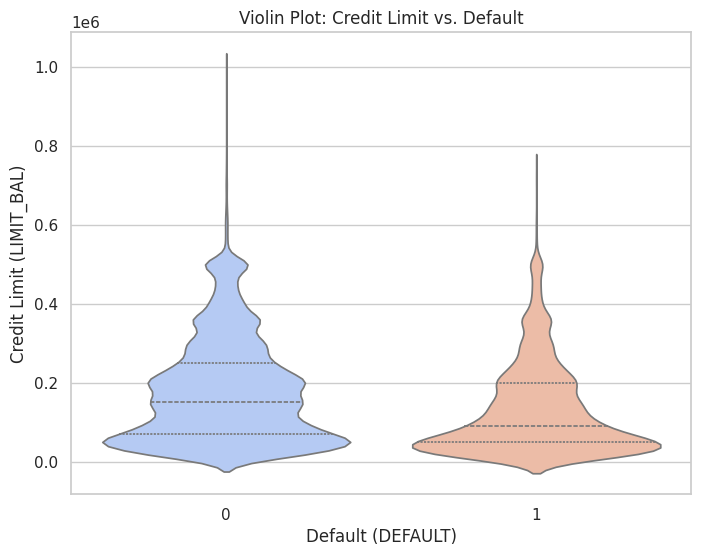

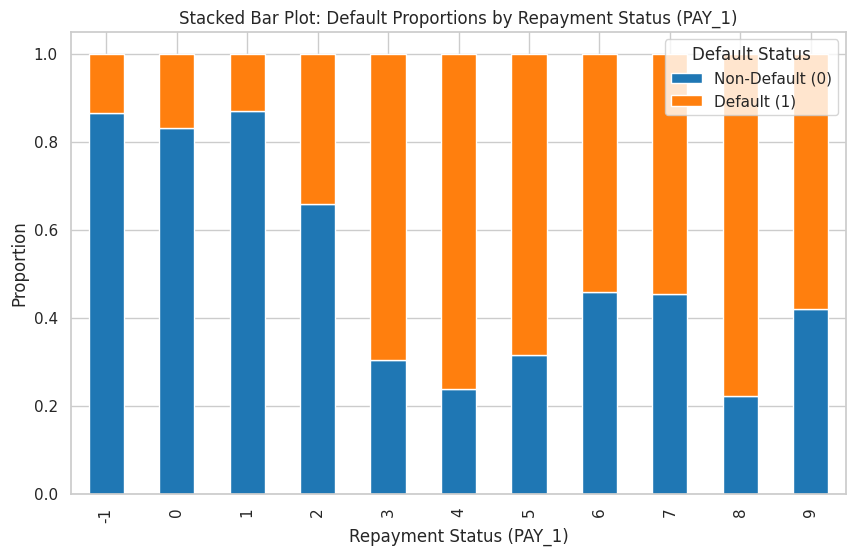

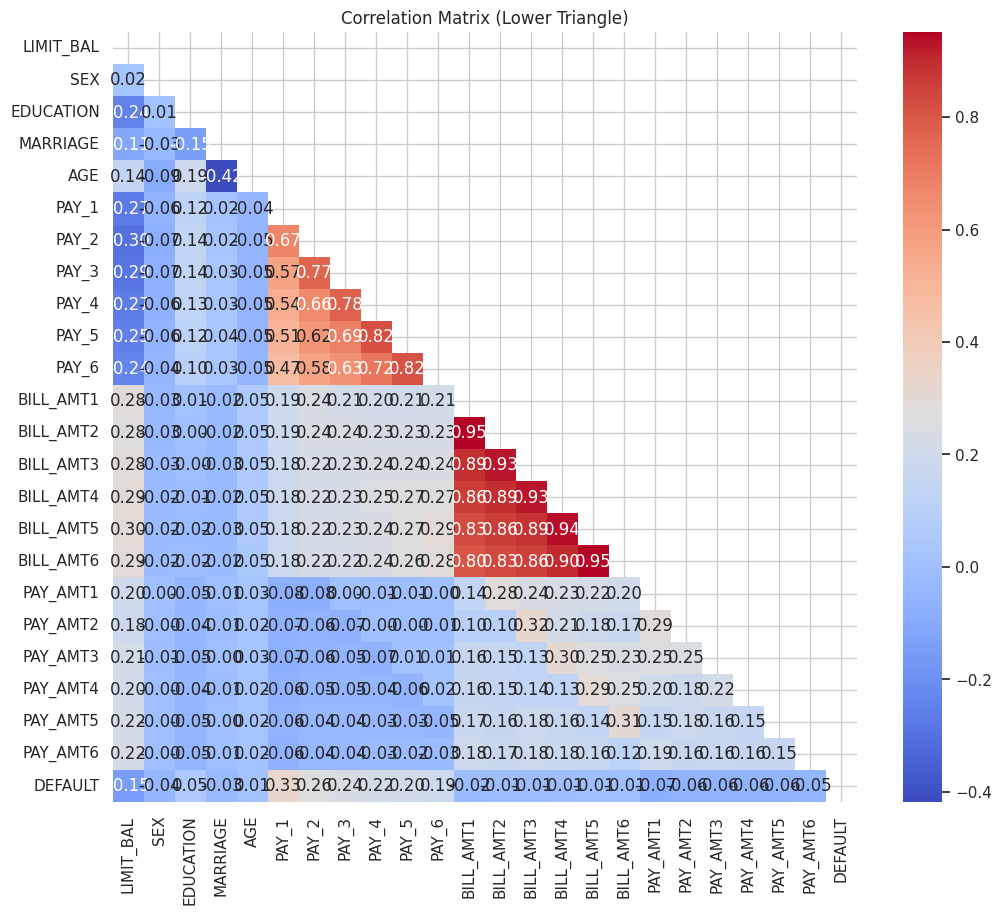

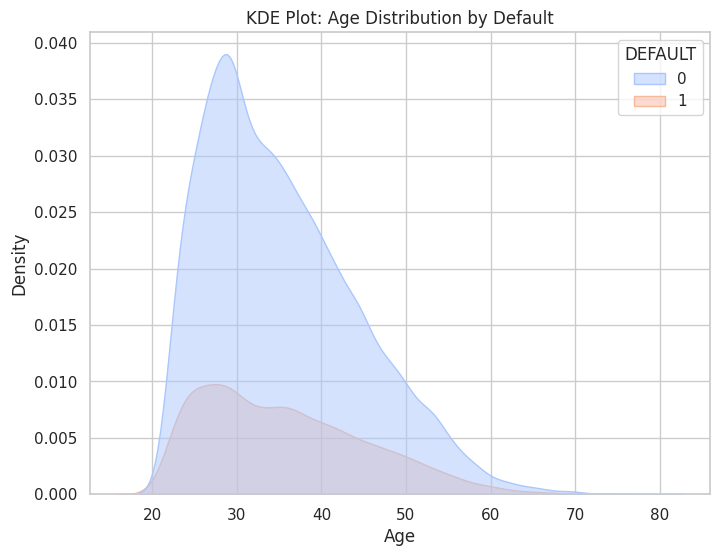

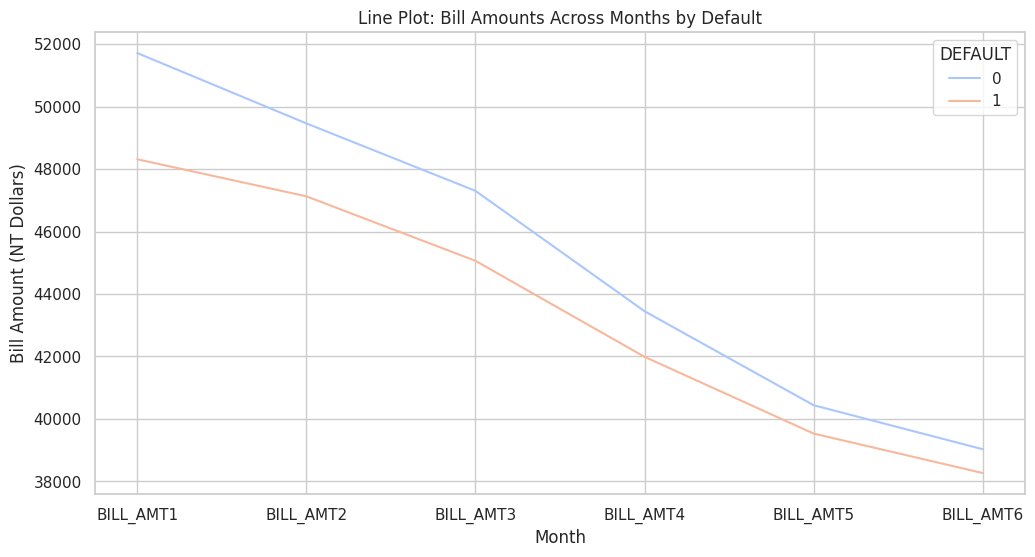

In [14]:
# Set a style for the plots
sns.set(style="whitegrid")

# 1. Scatter Plot: Credit Limit vs. Default
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='DEFAULT', y='LIMIT_BAL', palette='coolwarm', inner='quartile')
plt.title('Violin Plot: Credit Limit vs. Default')
plt.xlabel('Default (DEFAULT)')
plt.ylabel('Credit Limit (LIMIT_BAL)')
plt.show()

# 2. Box Plot: Payment History vs. Default
# Calculate proportions of default and non-default for each repayment status
pay_default = df.groupby('PAY_1')['DEFAULT'].value_counts(normalize=True).unstack()

# Plot a stacked bar chart
pay_default.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Stacked Bar Plot: Default Proportions by Repayment Status (PAY_1)')
plt.xlabel('Repayment Status (PAY_1)')
plt.ylabel('Proportion')
plt.legend(['Non-Default (0)', 'Default (1)'], title='Default Status')
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

# 4. Distribution Plot: Age
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='AGE', hue='DEFAULT', fill=True, palette='coolwarm', alpha=0.5)
plt.title('KDE Plot: Age Distribution by Default')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

# 5. Box Plot: Bill Amounts
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df_melted = df.melt(id_vars='DEFAULT', value_vars=bill_columns, var_name='Month', value_name='Bill Amount')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Month', y='Bill Amount', hue='DEFAULT', palette='coolwarm', ci=None)
plt.title('Line Plot: Bill Amounts Across Months by Default')
plt.xlabel('Month')
plt.ylabel('Bill Amount (NT Dollars)')
plt.show()

# Regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      6899
           1       0.72      0.24      0.36      1982

    accuracy                           0.81      8881
   macro avg       0.77      0.61      0.63      8881
weighted avg       0.80      0.81      0.77      8881

Confusion Matrix:
[[6713  186]
 [1502  480]]
ROC-AUC Score: 0.71


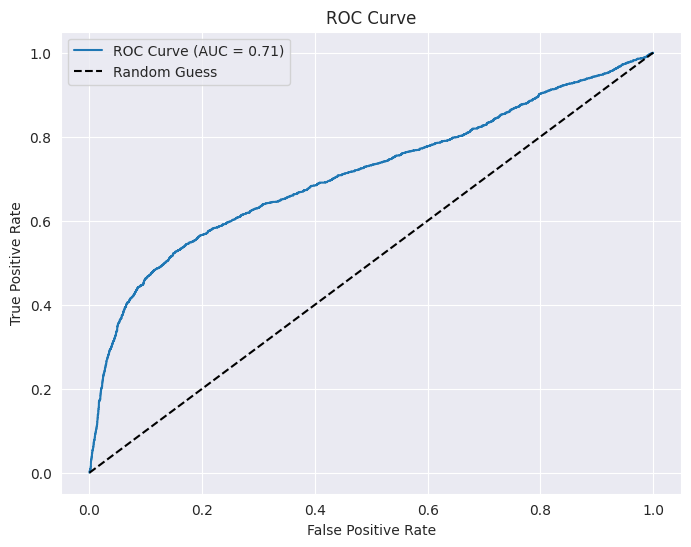

In [6]:
# Select features and target
features = ['LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
X = df[features]
y = df['DEFAULT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

1. Model Performance
Accuracy: 81%
The model correctly predicts the default status for 81% of the test data.
Precision:
For DEFAULT = 1 (defaulted customers), precision is 71%, meaning 71% of predicted defaults are correct.
For DEFAULT = 0 (non-defaulted customers), precision is 81%.
Recall:
For DEFAULT = 1, recall is 23%, meaning the model identifies only 23% of actual defaults.
For DEFAULT = 0, recall is 97%, meaning the model identifies most non-defaulted customers.
F1-Score:
For DEFAULT = 1, the F1-score is 35%, indicating poor performance in predicting defaults.
For DEFAULT = 0, the F1-score is 89%, showing strong performance in predicting non-defaults.
ROC-AUC Score: 0.71
The model has moderate discriminatory power in distinguishing between defaulted and non-defaulted customers.
2. Confusion Matrix
True Negatives (6712): Non-defaulted customers correctly classified.
False Positives (187): Non-defaulted customers misclassified as defaults.
False Negatives (1524): Defaulted customers misclassified as non-defaults.
True Positives (458): Defaulted customers correctly classified.
3. Insights
The model performs well in identifying non-defaulted customers but struggles to identify defaulted customers (low recall for DEFAULT = 1).
The imbalance in the dataset (22% default rate) likely contributes to the poor recall for defaults.

# Future Ideas
Address Class Imbalance:

Use techniques like oversampling or undersampling to balance the dataset.
Apply class weights in the logistic regression model (class_weight='balanced').

Feature Engineering:

Include additional features like BILL_AMT and PAY_AMT variables, which may improve predictive power.
Create interaction terms or transformations for key features (e.g., LIMIT_BAL to PAY_AMT ratio).

Try Advanced Models:

Use tree-based models like Random Forest or Gradient Boosting, which may better capture non-linear relationships.
Evaluate ensemble methods to improve recall for defaulted customers.

Threshold Tuning:

Adjust the decision threshold to improve recall for DEFAULT = 1 (e.g., lowering the threshold from 0.5 to 0.3).

Cross-Validation:

Perform k-fold cross-validation to ensure the model generalizes well across different subsets of the data.